In [49]:
import pandas as pd
import geopandas as gpd
import re
import os
from osgeo import gdal
import geopandas as gpd
import rasterio
import sys
import importlib
import re
import pandas as pd
import csv
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from rasterio.transform import from_bounds
from rasterio.features import rasterize
from pathlib import Path
import json

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# find helper scripts
project_root = Path.cwd().parent

# 2) Add that root to sys.path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
import pavc_funcs.standardize_pft_funcs as spf
importlib.reload(spf)

<module 'pavc_funcs.standardize_pft_funcs' from '/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/pavc_funcs/standardize_pft_funcs.py'>

---
# Helper functions

In [50]:
# rename columns for ESS-Dive
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.lower()

# throughout the script this will help keep my indices matching
def normalize_to_int_str(val):
    try:
        f = float(val)
        i = int(f)
        if f == i:
            return str(i)
    except (ValueError, TypeError):
        # now also catches the int(inf) case
        pass
    return str(val)

---
# 1. Create `survey_unit_information.csv`

In [51]:
# pft_fcover
sources = ['abr', 'akveg', 'ava', 'neon', 'nga']
aux_dfs = []
all_num_visits = []
for source in sources:
    path = f'../data/plot_data/{source}/output_data/{source}_plot_info.csv'
    df = pd.read_csv(path, index_col=0)
    
    # normalize index right away
    df.index.name = 'visit_id'
    df.columns = [camel_to_snake(col) for col in df.columns]
    all_num_visits.append(len(df))
    
    # set integer columns (after renaming)
    intcols = ['survey_year', 'survey_month', 'survey_day']
    for col in intcols:
        df[col] = df[col].astype('Int64')
    
    aux_dfs.append(df)

# combine all plot data
aux = pd.concat(aux_dfs)
print(f'Table-wise visits: {sum(all_num_visits)}\nAux table visits: {len(aux)}')

# drop data collected before 2010
aux = aux[aux['survey_year'] >= 2010]
print(f'Aux table visits on or after 2010: {len(aux)}')

Table-wise visits: 3246
Aux table visits: 3246
Aux table visits on or after 2010: 976


---
### Add some spatial information

In [52]:
# Create the GeoDataFrame by converting longitude and latitude to geometry
aux_gdf = gpd.GeoDataFrame(aux, geometry=gpd.points_from_xy(aux['longitude_x'], aux['latitude_y']))

# Get the bounding box coordinates
bounding_box = aux_gdf.total_bounds
minx, miny, maxx, maxy = bounding_box

# Bounding coordinates for ESS-Dive
northwest = (maxy, minx)  # (latitude, longitude) for northwest
southeast = (miny, maxx)  # (latitude, longitude) for southeast

print(f'Northwest (lat, lon): {northwest}')
print(f'Southeast (lat, lon): {southeast}')

Northwest (lat, lon): (71.32504, -165.97109)
Southeast (lat, lon): (64.7278975, -148.422128)


In [53]:
# add CAVM unit information
raster_path = '../data/supporting_data/cavm_raster/raster_cavm_v1.tif'
src = rasterio.open(raster_path)

# Load points
aux_gdf.crs = 'EPSG:4326'
aux_gdf = aux_gdf.to_crs(src.crs)

In [54]:
# sample raster at coordinates
coord_list = [(x, y) for x, y in zip(aux_gdf['geometry'].x, aux_gdf['geometry'].y)]
aux_gdf['raster_value'] = [x[0] for x in src.sample(coord_list)]

In [55]:
# load CAVM unit descriptions
legend_path = '../data/supporting_data/cavm_raster/raster_cavm_legend.csv'
legend_df = pd.read_csv(legend_path)

# ensure that 'cavm_zone' in aux_gdf and 'Raster code' in legend_df are of the same type before merging
aux_gdf['raster_value'] = aux_gdf['raster_value'].astype(str)
legend_df['Raster code'] = legend_df['Raster code'].astype(str)

# perform the left join
aux_gdf.reset_index(inplace=True)
new_aux_table = aux_gdf.merge(legend_df, left_on='raster_value', right_on='Raster code', how='left')
new_aux_table.drop(columns=['raster_value', 'Raster code', '# Pixels', 'Area  (1000 km2)', 'Long Description'], inplace=True)
new_aux_table.rename(columns={'Vegetation Unit':'cavm_unit', 'Short Description':'cavm_unit_description'}, inplace=True)
new_aux_table.set_index('visit_id', inplace=True)

../data/supporting_data/cavm_subzones_rast.tif → 0.0 MB


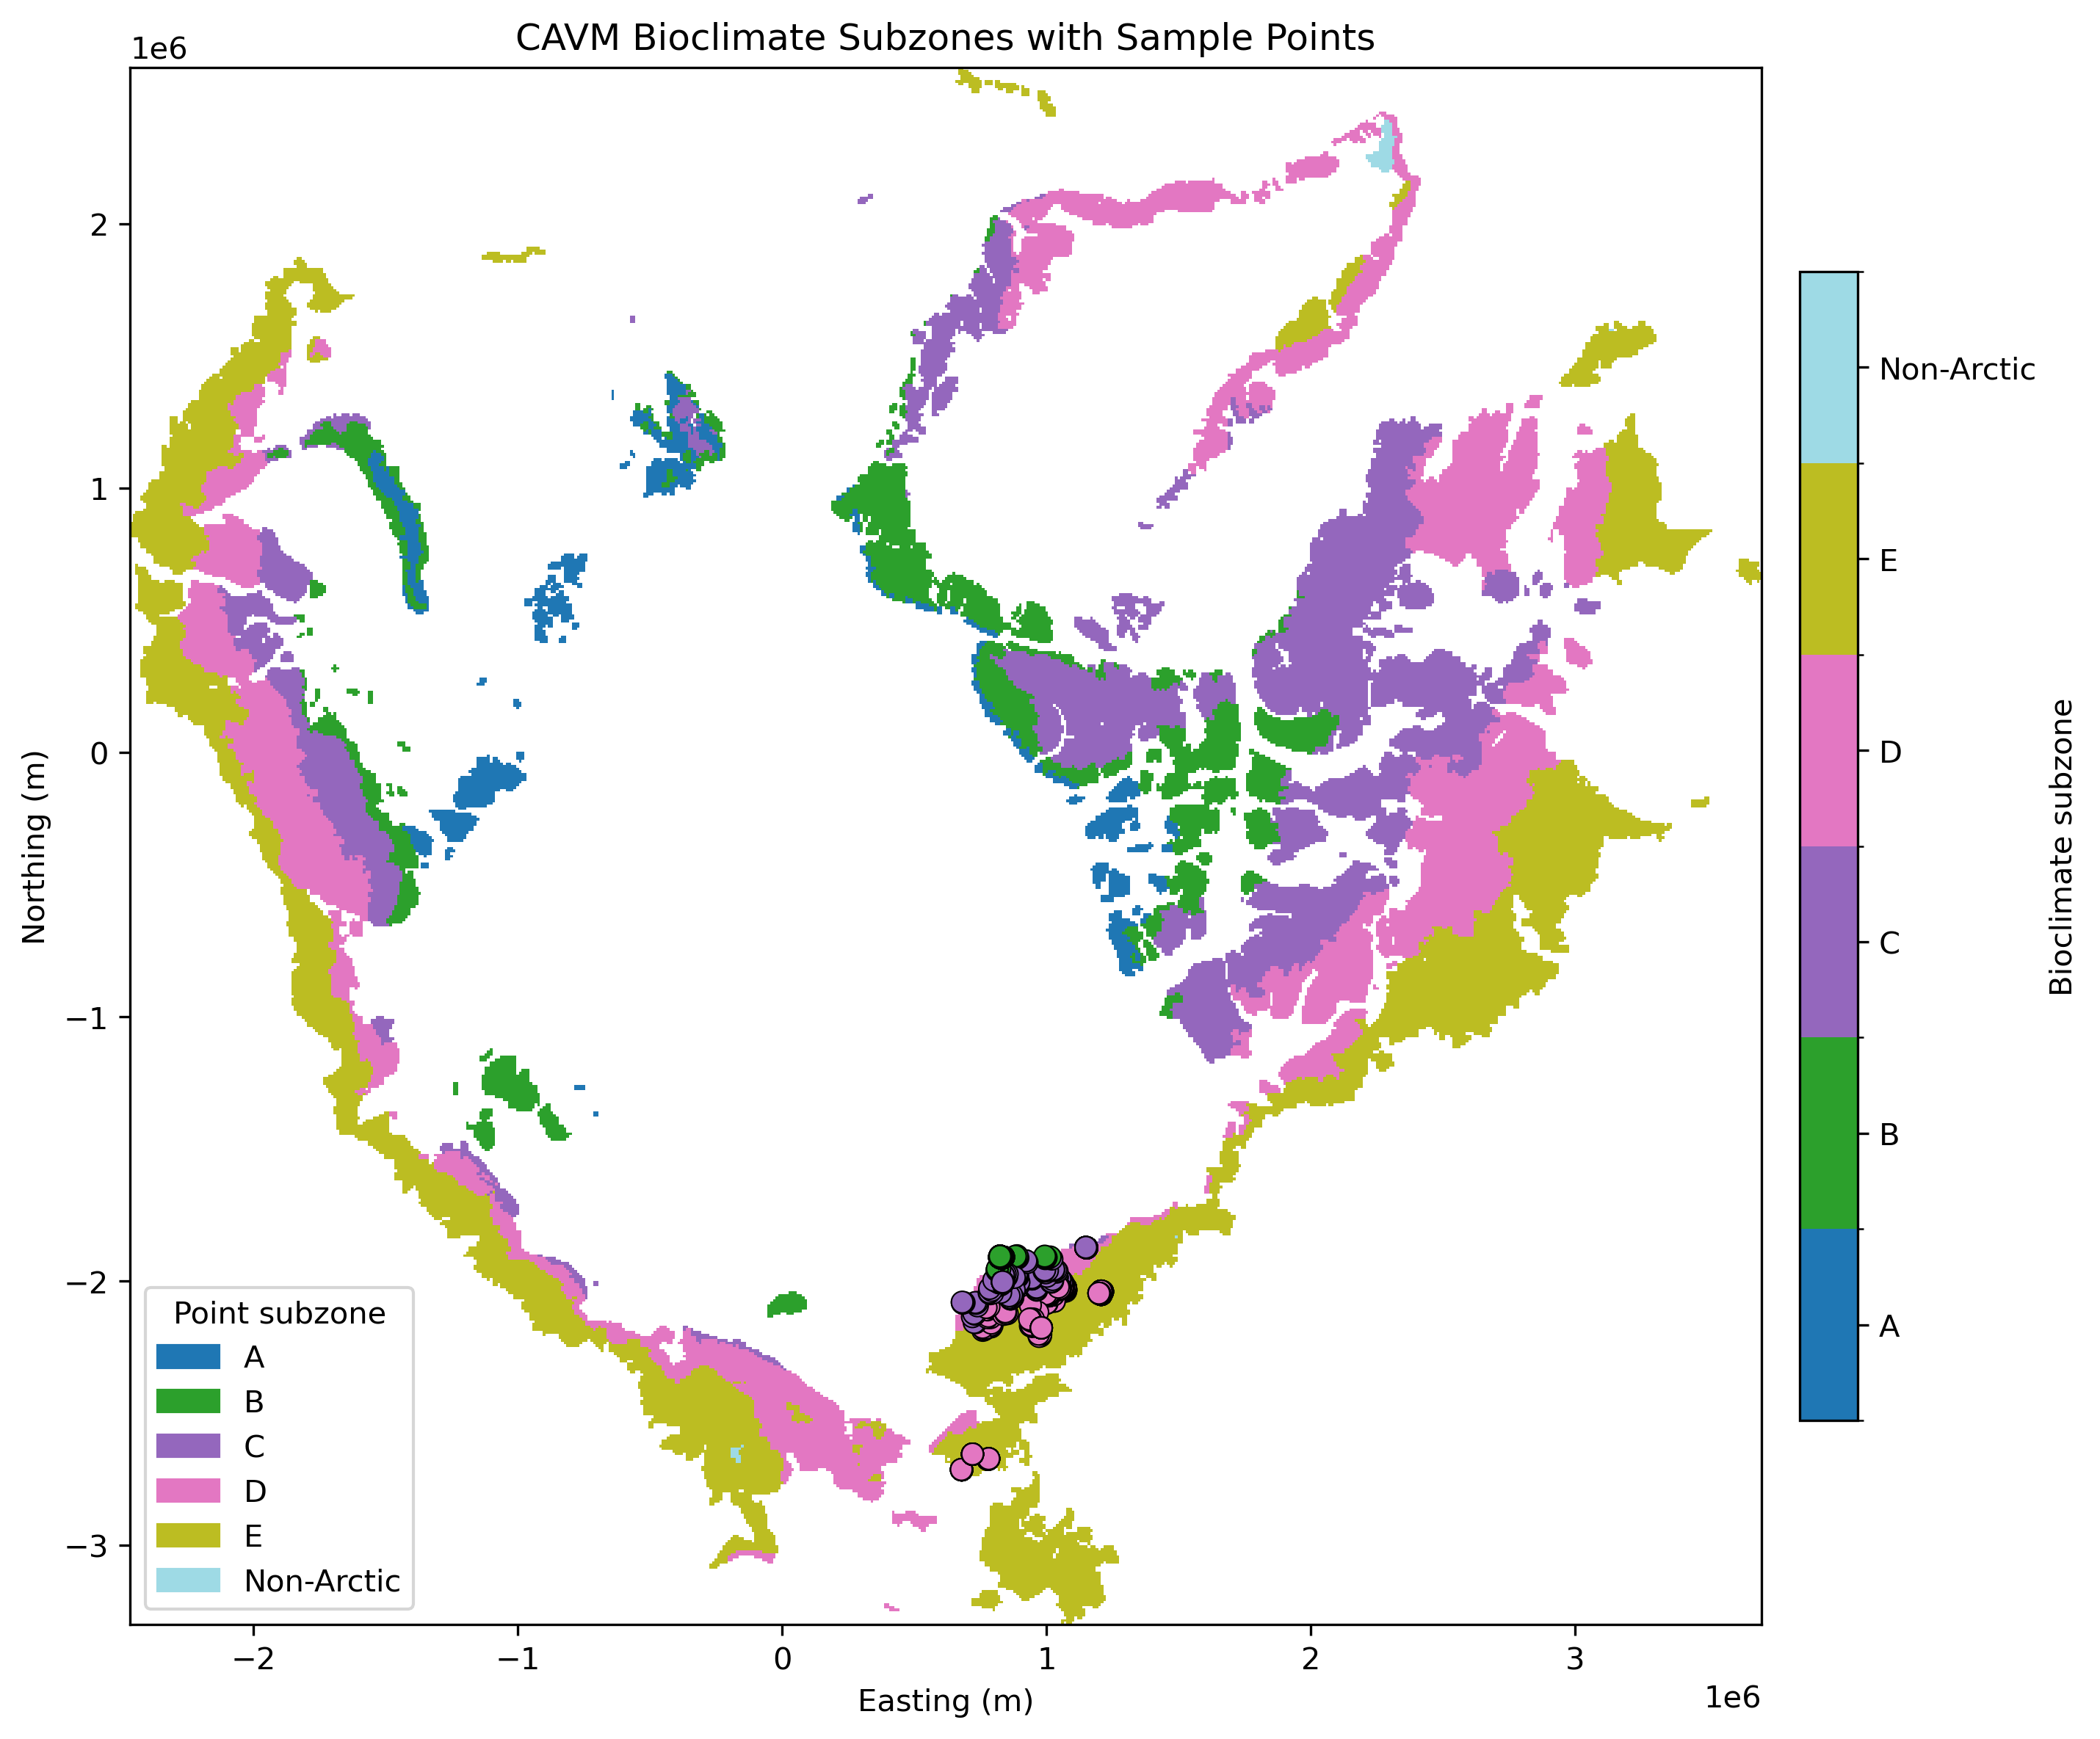

In [56]:
# Paths & parameters
vector_fn  = "../data/supporting_data/circumpolar_bioclim/aga_circumpolar_geobotanical_2003.shp"
raster_fn  = "../data/supporting_data/cavm_subzones_rast.tif"
pixel_size = 10000   # 10 km resolution in the native LAEA CRS
out_type   = gdal.GDT_UInt16

# Build and run the rasterize options
opts = gdal.RasterizeOptions(
    format          = "GTiff",
    outputType      = out_type,
    creationOptions = ["COMPRESS=LZW","TILED=YES","BIGTIFF=YES"],
    xRes            = pixel_size,
    yRes            = pixel_size,
    allTouched      = True,
    attribute       = "BIOZONE"
)
gdal.Rasterize(raster_fn, vector_fn, options=opts)

# Verify the file size
size = os.path.getsize(raster_fn)
print(f"{raster_fn} → {size/1e6:.1f} MB")

# 1) Load & mask the raster
src    = rasterio.open(raster_fn)
arr    = src.read(1)
bounds = src.bounds
masked = np.ma.masked_equal(arr, 0)
codes  = np.unique(masked.compressed())

# 2) Discrete colormap for those codes
zone_map    = {1:"A",2:"B",3:"C",4:"D",5:"E",6:"Non-Arctic"}
labels      = [zone_map[c] for c in codes]
cmap        = ListedColormap(plt.cm.tab20(np.linspace(0,1,len(codes))))
norm        = BoundaryNorm([c-0.5 for c in codes] + [codes[-1]+0.5], len(codes))

# 3) Prep your points (must have new_aux_table loaded with a valid .crs)
if new_aux_table.crs is None:
    raise ValueError("new_aux_table.crs is not set!")
pts = new_aux_table.to_crs(src.crs)

# 4) Sample, treating both 0 and 6 as “missing”
minx,miny,maxx,maxy = bounds
def sample(pt):
    x = np.clip(pt.x, minx, maxx)
    y = np.clip(pt.y, miny, maxy)
    v = next(src.sample([(x,y)]))[0]
    # treat raster 0 or 6 as missing
    return None if v in (0,6) else int(v)

pts["subzone_code"] = pts.geometry.apply(sample).astype("Int64")

# 5) Fallback: nearest polygon with BIOZONE != 6
gdf_pol = gpd.read_file(vector_fn).to_crs(src.crs)
gdf_pol = gdf_pol[gdf_pol["BIOZONE"] != 6].reset_index(drop=True)

def nearest(pt):
    d = gdf_pol.geometry.distance(pt)
    idx = d.values.argmin()
    return int(gdf_pol.iloc[idx]["BIOZONE"])

mask = pts["subzone_code"].isna()
pts.loc[mask, "subzone_code"] = pts.loc[mask, "geometry"].apply(nearest)

# 6) Map to labels
pts["bioclim_subzone"] = pts["subzone_code"].map(zone_map)

# 7) Plot raster + points
fig, ax = plt.subplots(figsize=(10, 8))

# raster background
im = ax.imshow(
    masked,
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
    origin="upper",
    cmap=cmap,
    norm=norm,
    interpolation="nearest",
    zorder=1
)
cbar = fig.colorbar(
    im, ax=ax,
    boundaries=codes, ticks=codes,
    fraction=0.03, pad=0.02
)
cbar.set_ticklabels(labels)
cbar.set_label("Bioclimate subzone")

# points overlay
code_to_idx = {c:i for i,c in enumerate(codes)}
ax.scatter(
    pts.geometry.x,
    pts.geometry.y,
    c=pts["subzone_code"].map(code_to_idx),
    cmap=cmap,
    norm=norm,
    edgecolor="black",
    s=50,
    linewidth=0.5,
    zorder=2,
    label="Sample points"
)

# legend for points
handles = [
    mpatches.Patch(color=cmap(norm(c)), label=zone_map[c]) 
    for c in codes
]
ax.legend(handles=handles, title="Point subzone", loc="lower left", framealpha=0.8)

ax.set_xlim(bounds.left, bounds.right)
ax.set_ylim(bounds.bottom, bounds.top)
ax.set_title("CAVM Bioclimate Subzones with Sample Points")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

In [57]:
# --- 1) Load GAUL1 shapefile (EPSG:4326) ---
vector_fn = "../data/supporting_data/gaul1/gaul1_asap.shp"
gdf = gpd.read_file(vector_fn).to_crs("EPSG:4326")

# --- 2) Define common raster grid (0.05° cells) ---
res       = 0.05
xmin, ymin, xmax, ymax = gdf.total_bounds
width     = int(np.ceil((xmax - xmin) / res))
height    = int(np.ceil((ymax - ymin) / res))
transform = from_bounds(xmin, ymin, xmax, ymax, width, height)

meta = {
    "driver":    "GTiff",
    "dtype":     "uint32",       # enough to hold 10-digit IDs
    "count":     1,
    "crs":       "EPSG:4326",
    "transform": transform,
    "width":     width,
    "height":    height,
    "compress":  "lzw",
}

# --- 3) Rasterize asap0_id → admin_country raster ---
out_country_tif = "../data/supporting_data/admin_country_rast.tif"
shapes0 = ((geom, int(code)) for geom, code in zip(gdf.geometry, gdf["asap0_id"]))
arr0    = rasterize(
    shapes0,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint32",
    all_touched=True
)
with rasterio.open(out_country_tif, "w", **meta) as dst:
    dst.write(arr0, 1)

# write legend for admin_country
pd.DataFrame({
    "admin_country_id": gdf["asap0_id"],
    "admin_country":    gdf["name0"]
}).drop_duplicates().to_csv("../data/supporting_data/admin_country_legend.csv", index=False)

# --- 4) Rasterize asap1_id → admin_unit raster ---
out_unit_tif = "../data/supporting_data/admin_unit_rast.tif"
shapes1 = ((geom, int(code)) for geom, code in zip(gdf.geometry, gdf["asap1_id"]))
arr1    = rasterize(
    shapes1,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint32",
    all_touched=True
)
with rasterio.open(out_unit_tif, "w", **meta) as dst:
    dst.write(arr1, 1)

# write legend for admin_unit
pd.DataFrame({
    "admin_unit_id": gdf["asap1_id"],
    "admin_unit":    gdf["name1"]
}).drop_duplicates().to_csv("../data/supporting_data/admin_unit_legend.csv", index=False)

print("Rasterization complete.")
print(f"  • {out_country_tif}")
print(f"  • {out_unit_tif}")
print("Legends:")
print("  • admin_country_legend.csv")
print("  • admin_unit_legend.csv")

Rasterization complete.
  • ../data/supporting_data/admin_country_rast.tif
  • ../data/supporting_data/admin_unit_rast.tif
Legends:
  • admin_country_legend.csv
  • admin_unit_legend.csv


In [58]:
# ensure your points are in EPSG:4326
pts = pts.copy()
if pts.crs is None:
    raise ValueError("pts.crs must be set!")
pts = pts.to_crs("EPSG:4326")

# shapefile for fallback
vector_fn = "../data/supporting_data/gaul1/gaul1_asap.shp"

def sample_with_fallback(raster_path, pts, code_field):
    # 1) open raster & get nodata
    with rasterio.open(raster_path) as src:
        bounds = src.bounds
        nodata = src.nodata if src.nodata is not None else 0

        # 2) clamp each point & sample
        coords = [
            (min(max(x, bounds.left),  bounds.right),
             min(max(y, bounds.bottom), bounds.top))
            for x, y in zip(pts.geometry.x, pts.geometry.y)
        ]
        vals = [v[0] for v in src.sample(coords)]

    # 3) assign an Int64 column
    pts[code_field] = pd.Series(vals, index=pts.index, dtype="Int64")

    # 4) build spatial index of GAUL1
    gdf = gpd.read_file(vector_fn).to_crs(pts.crs)
    sidx = gdf.sindex

    # 5) fallback nearest-code for nodata or missing
    def nearest_code(pt):
        idx = list(sidx.nearest(pt.bounds, 1))[0]
        return int(gdf.iloc[idx][code_field])

    mask = pts[code_field].isna() | (pts[code_field] == nodata)
    # apply fallback only where needed
    fallback = pts.loc[mask, "geometry"].apply(nearest_code)
    pts.loc[mask, code_field] = fallback

    return pts

# sample both rasters into asap0_id & asap1_id
pts = sample_with_fallback("../data/supporting_data/admin_country_rast.tif", pts, "asap0_id")
pts = sample_with_fallback("../data/supporting_data/admin_unit_rast.tif",    pts, "asap1_id")

# load legends and map IDs → labels
country_legend = (
    pd.read_csv("../data/supporting_data/admin_country_legend.csv")
      .set_index("admin_country_id")["admin_country"]
      .to_dict()
)

unit_legend = (
    pd.read_csv("../data/supporting_data/admin_unit_legend.csv")
      .set_index("admin_unit_id")["admin_unit"]
      .to_dict()
)

# now map
pts["admin_country"] = pts["asap0_id"].map(country_legend)
pts["admin_unit"]    = pts["asap1_id"].map(unit_legend)

# verify
print(pts[["asap0_id","admin_country","asap1_id","admin_unit"]].head())

            asap0_id             admin_country  asap1_id admin_unit
visit_id                                                           
u580f8d998         5  United States of America      1883     Alaska
u7237c5455         5  United States of America      1883     Alaska
u5a8ac1d8b         5  United States of America      1883     Alaska
u59bc4b4ea         5  United States of America      1883     Alaska
u28d3422f0         5  United States of America      1883     Alaska


/tmp/ipykernel_868936/3008677109.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(codes))


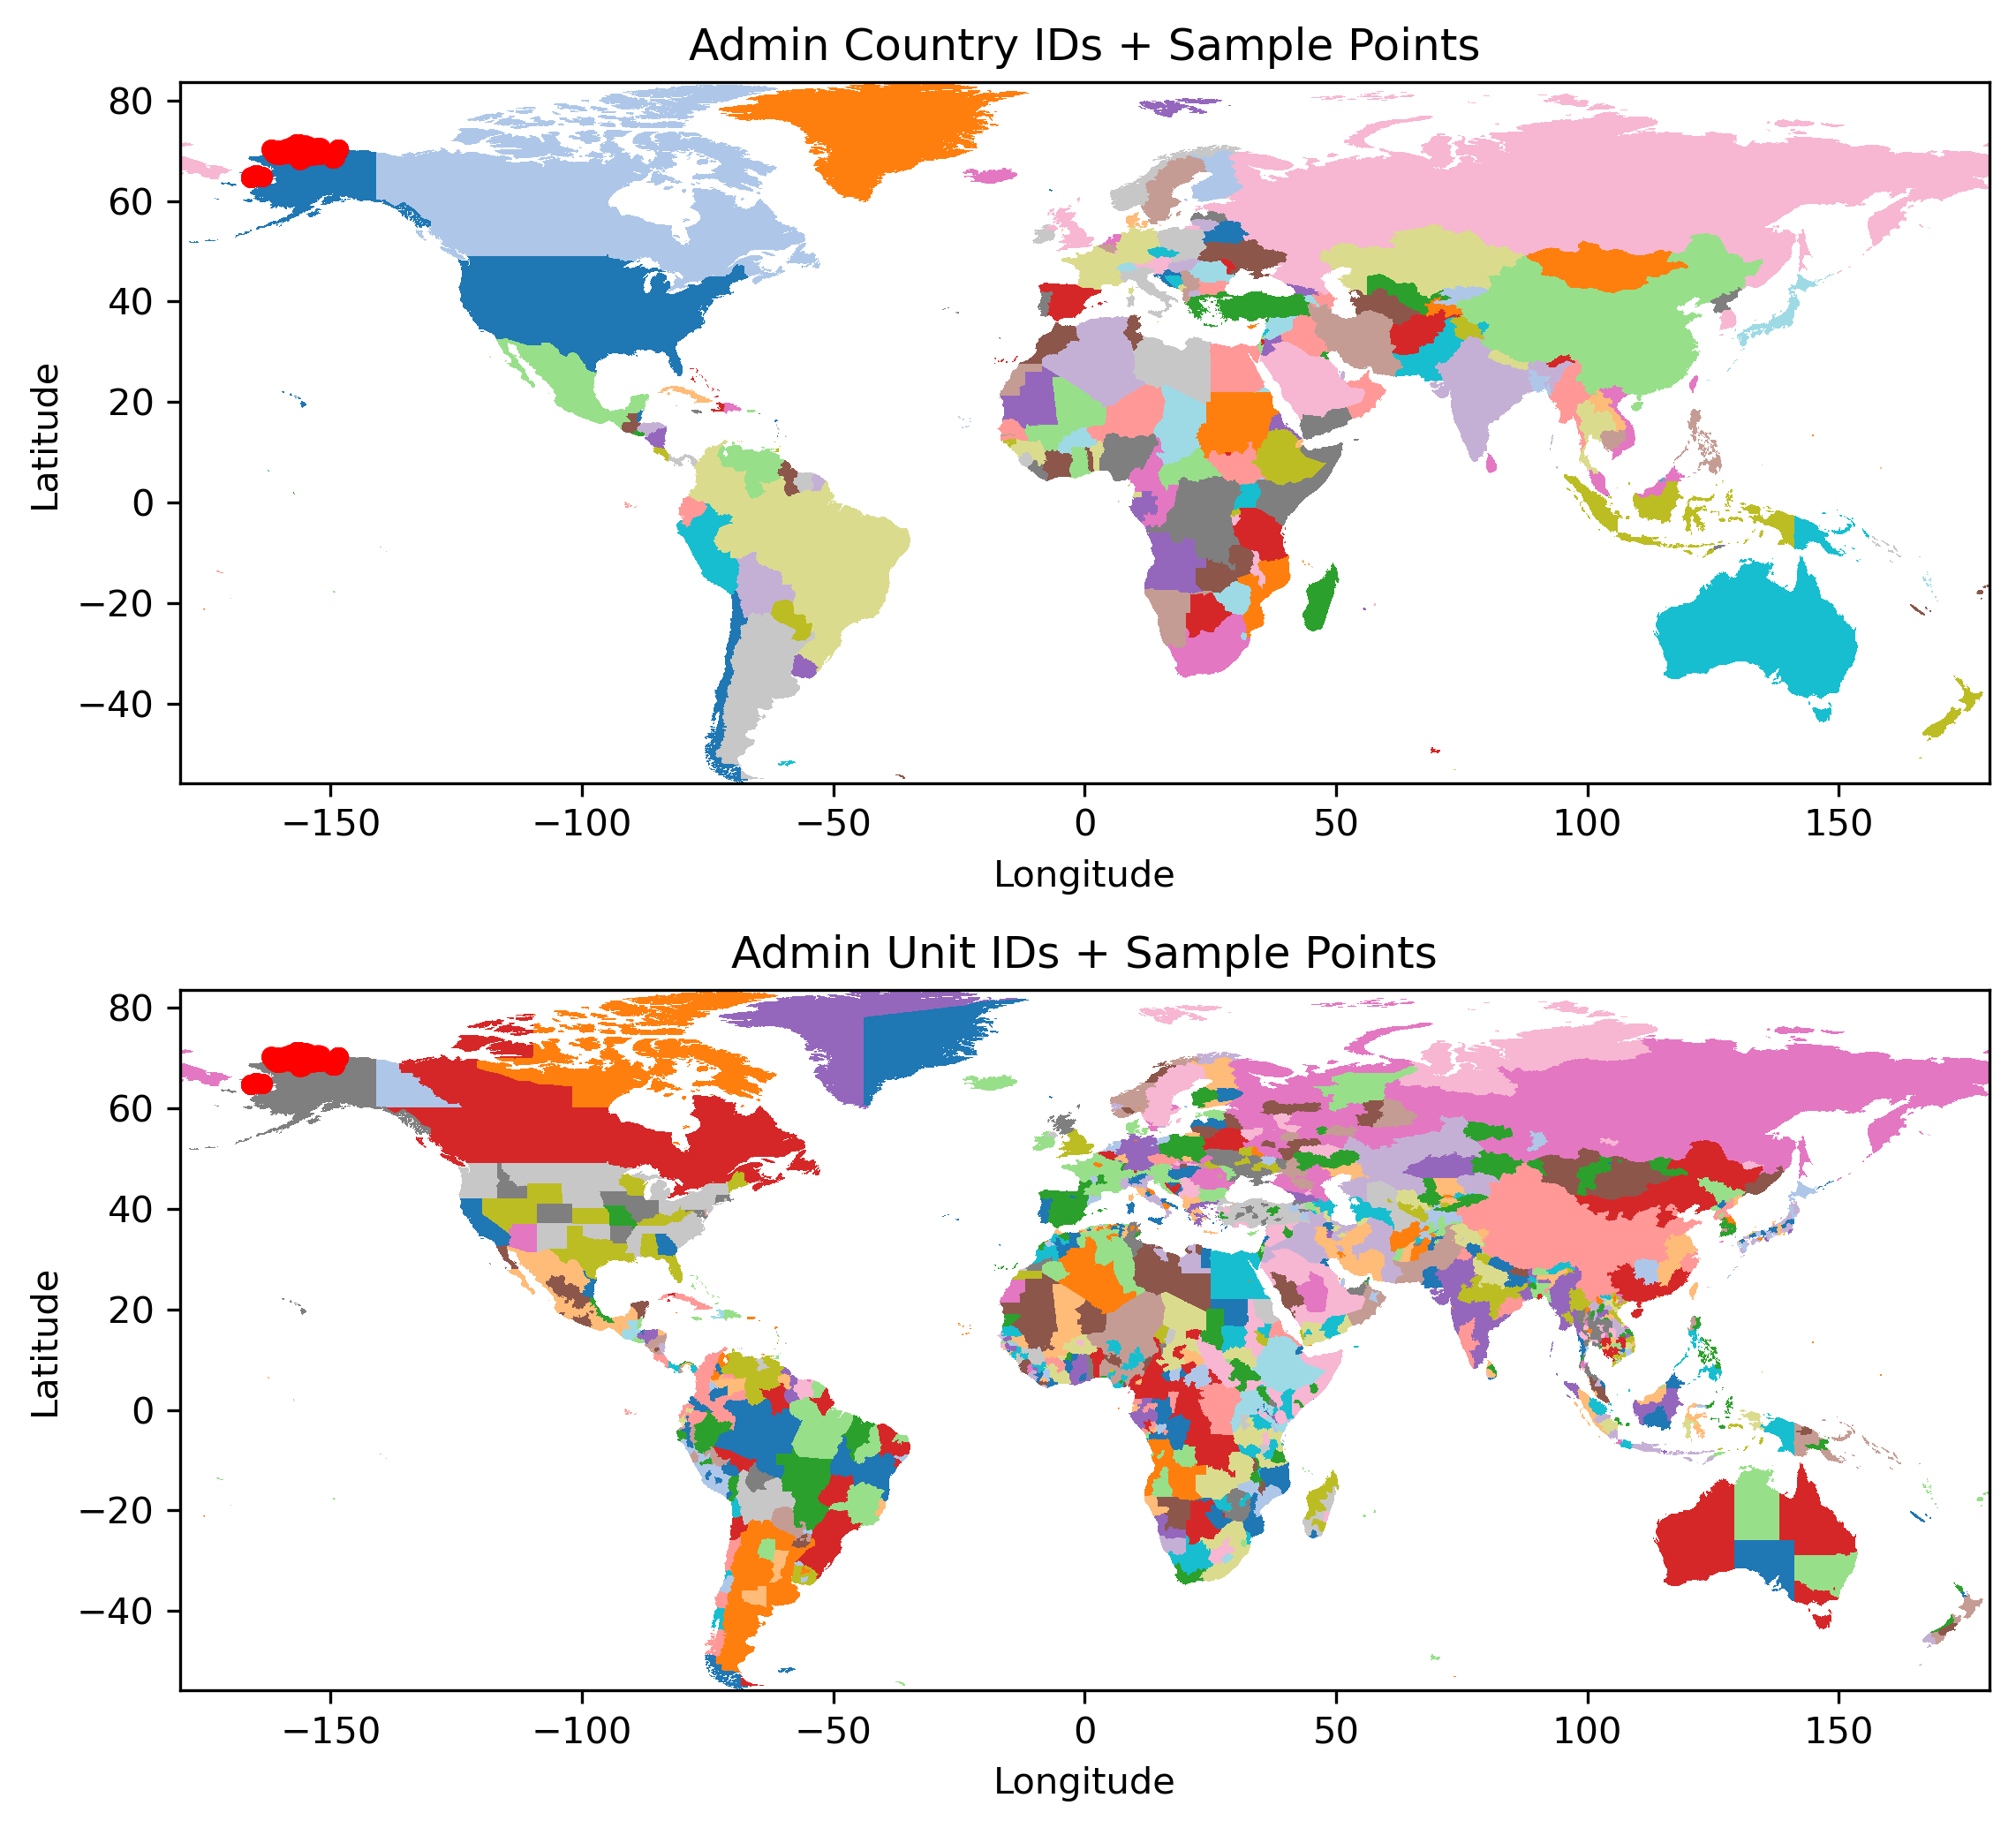

In [59]:
# paths to your newly created rasters
country_raster = "../data/supporting_data/admin_country_rast.tif"
unit_raster    = "../data/supporting_data/admin_unit_rast.tif"

# ensure pts is in EPSG:4326
pts_plot = pts.to_crs("EPSG:4326")

fig, axes = plt.subplots(2, 1, figsize=(16, 7))

for ax, (raster_path, title) in zip(
    axes,
    [
      (country_raster, "Admin Country IDs"),
      (unit_raster,    "Admin Unit IDs")
    ]
):
    with rasterio.open(raster_path) as src:
        arr    = src.read(1)
        bounds = src.bounds
        nodata = src.nodata if src.nodata is not None else 0

    # mask out nodata
    masked = np.ma.masked_equal(arr, nodata)
    codes  = np.unique(masked.compressed())

    # discrete colormap
    cmap = plt.cm.get_cmap("tab20", len(codes))
    norm = BoundaryNorm([c-0.5 for c in codes] + [codes[-1]+0.5], cmap.N)

    # plot raster
    im = ax.imshow(
        masked,
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
        origin="upper",
        cmap=cmap,
        norm=norm,
        interpolation="nearest"
    )

    # overlay points in black
    ax.scatter(
        pts_plot.geometry.x,
        pts_plot.geometry.y,
        color="red",
        s=20,
        alpha=0.7,
        zorder=2
    )

    ax.set_title(f"{title} + Sample Points")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

In [60]:
pts.columns

Index(['survey_year', 'survey_month', 'survey_day', 'plot_area', 'plot_shape',
       'latitude_y', 'longitude_x', 'georef_source', 'georef_accuracy',
       'coord_epsg', 'plot_name', 'data_subsource', 'data_source',
       'data_source_html', 'data_subsource_citation', 'survey_method',
       'fcover_scale', 'survey_purpose', 'fire_years', 'duplicated_coords',
       'duplicated_date', 'geometry', 'cavm_unit', 'cavm_unit_description',
       'subzone_code', 'bioclim_subzone', 'asap0_id', 'asap1_id',
       'admin_country', 'admin_unit'],
      dtype='object')

### Create data descriptor file

In [61]:
# UNITS_AND_DEFS = { col: {"unit": "", "definition": ""} for col in out_aux.columns }
# print(json.dumps(UNITS_AND_DEFS, indent=4))

In [62]:
# fill in missing information
dd_info = {
        "visit_id": {
        "unit": 1,
        "definition": "A unique identifier representing the survey unit visitation at a particular survey unit; some survey units are visited more than once"
    },
    "survey_year": {
        "unit": 1,
        "definition": "The year in which field data were collected"
    },
    "survey_month": {
        "unit": 1,
        "definition": "The month in which field data were collected"
    },
    "survey_day": {
        "unit": 1,
        "definition": "The day in which field data were collected"
    },
    "plot_area": {
        "unit": "meter",
        "definition": "The area of the survey unit shape in meters"
    },
    "plot_shape": {
        "unit": 1,
        "definition": "The shape of the survey unit"
    },
    "latitude_y": {
        "unit": "degree",
        "definition": "The latitude (y coordinate) of a survey unit centroid"
    },
    "longitude_x": {
        "unit": "degree",
        "definition": "The longitude (x coordinate) of a survey unit centroid"
    },
    "georef_source": {
        "unit": 1,
        "definition": "The device used to georeference a survey unit centroid"
    },
    "georef_accuracy": {
        "unit": "meter",
        "definition": "The spatial accuracy of the georeferencing source"
    },
    "coord_epsg": {
        "unit": 1,
        "definition": "The coordinate system in which the survey unit centroid coordinates are stored"
    },
    "plot_name": {
        "unit": 1,
        "definition": "The non-unique name of the survey unit that was visited"
    },
    "data_subsource": {
        "unit": 1,
        "definition": "A description of the study associated with a survey unit"
    },
    "data_source": {
        "unit": 1,
        "definition": "A code representing the data store or database that the survey unit data was accessed from (AVA=Arctic Vegetation Archive of Alaska; ABR=Shell Onshore/Nearshore Environmental Studies program data collected by ABR, Inc; NEON=National Ecological Observatory Network; AKVEG=Alaska Vegetation Plots Database; NGA=NGEE-Arctic)"
    },
    "data_source_html": {
        "unit": 1,
        "definition": "Link(s) to the webpage used for downloading data"
    },
    "data_subsource_citation": {
        "unit": 1,
        "definition": "Data subsource (field study) citation formatted according to Nature guidelines"
    },
    "survey_method": {
        "unit": 1,
        "definition": "The general method employed by surveyors for collecting fcover data in the field (qudrat, transect-quadrat, and center-staked point-intercept)"
    },
    "fcover_scale": {
        "unit": 1,
        "definition": "The scale used when collecting fcover (e.g., percent, braun-blanquet, etc.)"
    },
    "survey_purpose": {
        "unit": 1,
        "definition": "A general statement derived from the source's paper that summarizes the purpose of field work"
    },
    "admin_unit": {
        "unit": 1,
        "definition": "The lower-level administrative unit in which the survey unit data was collected"
    },
    "admin_country": {
        "unit": 1,
        "definition": "The country in which the survey unit data was collected"
    },
    "fire_years": {
        "unit": 1,
        "definition": "A list of years in which fire occurred on the survey unit"
    },
    "bioclim_subzone": {
        "unit": 1,
        "definition": "The CAVM bioclimate subzone represented as A-E"
    },
    "duplicated_coords": {
        "unit": 1,
        "definition": "A list of unit_id(s) that have duplicate coordinates; this may imply that a particular survey unit was returned to but given a new name"
    },
    "duplicated_date": {
        "unit": 1,
        "definition": "A list of unit_id(s) that were collected on the same date"
    },
    "cavm_unit": {
        "unit": 1,
        "definition": "The circumpolar arctic vegetation map (CAVM) unit associated with the coordinates of the survey unit"
    },
    "cavm_unit_description": {
        "unit": 1,
        "definition": "The circumpolar arctic vegetation map (CAVM) unit's short description associated with the coordinates of the survey unit"
    }
}

In [63]:
import pandas as pd
import typing
from typing import get_origin, get_args

from pavc_funcs.schemas import SCHEMAS
SynthesizedAux = SCHEMAS["synthesized_aux"]

dtype_map = {}
for name, field in SynthesizedAux.model_fields.items():
    t      = field.annotation
    origin = get_origin(t)
    args   = get_args(t)

    # 1) Explicit primitives
    if t is str:
        pd_type = "string"
    elif t is float:
        pd_type = "float64"
    elif t is int:
        pd_type = "Int64"            # nullable int

    # 2) Optionals
    elif origin is typing.Union and set(args) == {int, type(None)}:
        pd_type = "Int64"
    elif origin is typing.Union and set(args) == {str, type(None)}:
        pd_type = "string"
    elif origin is typing.Union and set(args) == {float, type(None)}:
        pd_type = "float64"

    # 3) Lists stay object
    elif origin in (list, typing.List):
        pd_type = "object"

    # 4) Everything else → string
    else:
        pd_type = "string"

    dtype_map[name] = pd_type

# cast in one go
pts.drop(columns=['asap0_id', 'asap1_id', 'subzone_code'], inplace=True)
out_aux = spf.validate_synthesized_aux(pts)
out_aux = out_aux.reset_index() 
out_aux = out_aux.astype(dtype_map)

# build your DD exactly as before
rows = []
for col in out_aux.columns:
    meta = dd_info.get(col, {"unit": "", "definition": ""})
    rows.append({
        "column_name":      col,
        "unit":             meta["unit"],
        "definition":       meta["definition"],
        "column_long_name": col,
        "data_type":        out_aux[col].dtype.name
    })

dd_df = pd.DataFrame(rows, columns=[
    "column_name","unit","definition","column_long_name","data_type"
])

In [64]:
dd_df

,column_name,unit,definition,column_long_name,data_type
0,visit_id,1,A unique identifier representing the survey un...,visit_id,string
1,survey_year,1,The year in which field data were collected,survey_year,Int64
2,survey_month,1,The month in which field data were collected,survey_month,Int64
3,survey_day,1,The day in which field data were collected,survey_day,Int64
4,plot_area,meter,The area of the survey unit shape in meters,plot_area,float64
5,plot_shape,1,The shape of the survey unit,plot_shape,string
6,latitude_y,degree,The latitude (y coordinate) of a survey unit c...,latitude_y,float64
7,longitude_x,degree,The longitude (x coordinate) of a survey unit ...,longitude_x,float64
8,georef_source,1,The device used to georeference a survey unit ...,georef_source,string
9,georef_accuracy,meter,The spatial accuracy of the georeferencing source,georef_accuracy,float64


In [65]:
out_aux.set_index('visit_id', inplace=True)
out_aux = spf.validate_synthesized_aux(out_aux)
out_aux.to_csv('../pavc/survey_unit_information.csv', encoding="utf-8-sig", quoting=csv.QUOTE_ALL)

In [66]:
dd_df.to_csv('../pavc/survey_unit_information_dd.csv', encoding='utf-8-sig', quoting=csv.QUOTE_ALL, index=False)

---
### Aux summary statistics

In [22]:
# number of plots per source
aux = out_aux.copy()
aux.reset_index().groupby('data_source').count()['visit_id']

data_source
ABR      107
AKVEG    184
AVA      308
NEON     280
NGA       97
Name: visit_id, dtype: int64

In [23]:
# number of plots per data subsource
aux.reset_index().groupby('data_subsource').count()['visit_id']

data_subsource
AIM NPR-A Nawrocki (pub 2020)                    184
Atqasuk Villarreal (pub 2013)                     31
Barrow DOE NGEE Sloan (pub 2014)                  48
Barrow IBP Tundra Biome Villarreal (pub 2012)     33
Flux Tower Zona Davidson (pub 2016)              140
NGEE-Arctic Amy Breen (pub 2020)                  97
Prudhoe ArcSEES road study Walker (pub 2015)      29
Prudhoe Bay Airport ArcSEES Walker (pub 2016)     27
Shell Onshore Macander (pub 2017)                107
Toolik Field Station NEON (pub 2021)              84
Utqiagvik-Barrow NEON (pub 2021)                 196
Name: visit_id, dtype: int64

In [24]:
# average plot area per survey method
aux.groupby(['survey_method'])['plot_area'].agg(['mean', 'count', 'sum', 'min', 'max'])

,mean,count,sum,min,max
survey_method,,,,,
center-staked point-intercept along transect,5328.022386,291,1.550455e+06,2827.433388,9503.317777
plot along transect,1.000000,168,1.680000e+02,1.000000,1.000000
simple plot,2.160621,517,1.117041e+03,1.000000,19.634954


In [25]:
# average plots area per data source and plot shape
aux.groupby(['data_source', 'plot_shape'])['plot_area'].agg(['mean', 'count', 'sum', 'min', 'max'])

mean  count           sum  \
data_source plot_shape                                              
ABR         circle               9503.317777    107  1.016855e+06   
AKVEG       circle               2899.997349    184  5.335995e+05   
AVA         irregular               1.000000     13  1.300000e+01   
            linear/band-forming     1.000000     51  5.100000e+01   
            square                  1.000000    244  2.440000e+02   
NEON        square                  1.000000    280  2.800000e+02   
NGA         circle                  7.185988     97  6.970409e+02   

                                         min          max  
data_source plot_shape                                     
ABR         circle               9503.317777  9503.317777  
AKVEG       circle               2827.433388  9503.317777  
AVA         irregular               1.000000     1.000000  
            linear/band-forming     1.000000     1.000000  
            square                  1.000000     1.000000  
NEON        square                  1.000000     1.000000  
NGA         circle                  4.908739    19.634954

In [26]:
# get data date ranges
aux_temp = aux.dropna(subset=['survey_year', 'survey_month', 'survey_day']).copy()

# create a new date column from year, month, and day, explicitly naming the columns
aux_temp['date'] = pd.to_datetime(aux_temp[['survey_year', 'survey_month', 'survey_day']].rename(columns={
    'survey_year': 'year', 
    'survey_month': 'month', 
    'survey_day': 'day'
}), errors='coerce')

# find the oldest date, skipping invalid dates
oldest_date = aux_temp['date'].min()
most_recent_date = aux_temp['date'].max()

print("Oldest date:", oldest_date)
print("Most resecent date:", most_recent_date)

Oldest date: 2010-08-01 00:00:00
Most resecent date: 2021-08-07 00:00:00


---
# 2. Create `synthesized_pft_fcover.csv`

In [ ]:
# pft_fcover
sources = ['abr', 'akveg', 'ava', 'neon', 'nga']
pft_dfs = []
all_num_visits = []
for src in sources:
    df = pd.read_csv(f'{src}/output_data/{src}_standard_pft_fcover.csv',
                     index_col=0, encoding='utf-8-sig')
    df.columns = [camel_to_snake(c) for c in df.columns]
    df.index.name = 'visit_id'
    pft_dfs.append(df)
    all_num_visits.append(len(df.index))
print(f'Table-wise visits: {sum(all_num_visits)}')

# adjust column names and index
pft_fcover = pd.concat(pft_dfs)
print(f'PFT-fcover table visits: {len(pft_fcover)}')

# subselect pft_fcover data collected before 2010
subset_pft_fcover = pft_fcover.loc[aux.index]
print(f'PFT-fcover table visits on or after 2010: {len(subset_pft_fcover)}')

In [ ]:
# ensure the data are formatted correctly and makes sense
pft_fcover_df = spf.validate_synthesized_pft_fcover(subset_pft_fcover)
pft_fcover_df.set_index('visit_id', drop=True, inplace=True)

In [ ]:
# address coverage less than 100%
temp = pft_fcover_df.merge(aux, how='left', left_index=True, right_index=True)

# columns to exclude in summing
exclude = {'nonvascular_sum_cover'}

# identify *_cover cols, minus nonvascular_sum_cover
cover_cols = [
    c for c in df.columns
    if c.endswith('_cover') and c not in exclude
]

# get rows less summing than 100
row_sums = df[cover_cols].sum(axis=1)
mask = row_sums < 100
df_under100 = (
    df
    .loc[mask]            # all columns, only rows where sum<100
    .copy()               # avoid SettingWithCopyWarning
    .assign(total_sum=row_sums[mask])
)

In [ ]:
# determine the culprit of data summing to <100
df_under100.merge(aux[['data_source', 'data_subsource']], 
                  how='left', left_index=True, right_index=True)

In [ ]:
# export pft_fcover
pft_fcover_df = pft_fcover_df.replace({None: np.nan, '':np.nan})
pft_fcover_df.to_csv('synthesized_pft_fcover.csv', index=True, encoding='utf-8-sig')

## 2.b. Fill in missing plot information variables manually
Save as `survey_unit_information.csv` in main directory
- Manual assessment because some rows missing admin_unit, admin_country, bioclim_subzone

## 2.c. Summarize final plot information table

#### Columns

## 3. Plot PFT distribution

In [ ]:
# Initialize the MinMaxScaler with the desired feature range
# scaler = MinMaxScaler(feature_range=(0, 100))

# Fit and transform the data
cover_cols = [col for col in pft_fcover.columns if 'cover' in col]
# pft_fcover_scaled = pd.DataFrame(scaler.fit_transform(pft_fcover[cover_cols]), columns=cover_cols)
pft_fcover_scaled = pd.DataFrame(pft_fcover[cover_cols], columns=cover_cols)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# List of fcover types
fcover_types = ['deciduous_shrub_cover', 'deciduous_tree_cover', 'evergreen_shrub_cover', 'evergreen_tree_cover',
                'forb_cover', 'graminoid_cover', 'bryophyte_cover', 'lichen_cover',
                'other_cover', 'litter_cover', 'bareground_cover', 'water_cover']

# Number of subplots
num_subplots = len(fcover_types)
nrows = 3
ncols = ceil(num_subplots / nrows)

# Determine common x and y ranges, excluding zeros
all_values_nonzero = pd.concat([pft_fcover_scaled[col][pft_fcover_scaled[col] > 0].dropna() for col in fcover_types])
x_min_nonzero, x_max = all_values_nonzero.min(), all_values_nonzero.max()

# Create a figure and subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10), sharex=True)

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Define bin edges, excluding 0
bin_width = 10
bin_edges = np.arange(x_min_nonzero, x_max + bin_width, bin_width)

# Y-axis limits and colors
y_axis_limits = {
    'Deciduous Shrub': (1000, '#b5c58f'),
    'Deciduous Tree': (1000, '#b5c58f'),
    'Evergreen Shrub': (1000, '#b5c58f'),
    'Evergreen Tree': (1000, '#b5c58f'),
    'Forb': (1000, '#b5c58f'),
    'Graminoid': (1000, '#b5c58f'),
    'Bryophyte': (1000, '#b5c58f'),
    'Lichen': (1000, '#b5c58f'),
    'Litter': (1000, 'wheat'),
    'Other': (1000, '#b5c58f'),
    'Water': (1000, 'lightblue'),
    'Bareground': (1000, 'wheat')
}

# Format fcover titles
def format_fcover_title(fcover_type):
    return fcover_type.replace('_cover', '').replace('_', ' ').title()

# Plot each fcover type
for i, fcover_type in enumerate(fcover_types):
    title = format_fcover_title(fcover_type)
    y_limit, color = y_axis_limits.get(title, (40, 'lightgray'))  

    # Filter data to exclude zeros
    data_nonzero = pft_fcover[fcover_type][pft_fcover[fcover_type] > 0].dropna()
    
    # Generate histogram with align='mid' to prevent cutoff
    n, bins, patches = axs[i].hist(
        data_nonzero, 
        bins=bin_edges, 
        color=color, 
        edgecolor='black', 
        align='mid'  # Center bin values
    )

    # Calculate bin centers
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Set x-ticks at bin centers
    tick_spacing = 2
    axs[i].set_xticks(bin_centers[::tick_spacing])
    axs[i].set_xticklabels([f"{int(center)}" for center in bin_centers[::tick_spacing]])
    
    axs[i].set_title(title, fontsize=14)
    
    # Adjust x-axis limits to prevent leftmost cutoff
    axs[i].set_xlim(x_min_nonzero - bin_width / 2, x_max + bin_width / 2)  

    axs[i].set_ylim(0, 600)
    axs[i].tick_params(axis='both', which='major', labelsize=11)
    axs[i].xaxis.set_tick_params(labelbottom=True)
    
    # Set x-axis label only for the bottom row
    if i >= (nrows - 1) * ncols:
        axs[i].set_xlabel('Percent fractional cover', fontsize=12)
    
    # Set y-axis label only for the far-left column
    if i % ncols == 0:
        axs[i].set_ylabel('Frequency', fontsize=12)

# Remove empty subplots
for j in range(num_subplots, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
pft_fcover_scaled[pft_fcover_scaled['other_cover'] != 0]

In [ ]:
plots_w_other = len(pft_fcover_scaled[(pft_fcover_scaled['other_cover'] != 0) & (~pft_fcover_scaled['other_cover'].isna())]) / len(pft_fcover_scaled)
print('Percent of plots containing "other" cover:', round(plots_w_other * 100, 2))

In [ ]:
# Count how many "other_cover" values are nonzero and not NaN
other_nonzero = (pft_fcover_scaled['other_cover'].notnull() & (pft_fcover_scaled['other_cover'] != 0)).sum()

# Count total number of nonzero and non-NaN values across the entire DataFrame
total_nonzero_nonnull = (pft_fcover_scaled.notnull() & (pft_fcover_scaled != 0)).sum().sum()

# Calculate the percent
other_vals_per_total = other_nonzero / total_nonzero_nonnull
print('Percent of all non-zero cover that is "other" cover:', round(other_vals_per_total * 100, 2))

In [ ]:
mask = (pft_fcover_scaled['other_cover'] != 0) & (pft_fcover_scaled['other_cover'].notna())
median_other_cover = pft_fcover_scaled.loc[mask, 'other_cover'].median()
median_other_cover

---
# 6. Plot overlap with CAVM zones if not in aux

---
## Show intersection of plot data with CAVM Zones

In [ ]:
import xml.etree.ElementTree as ET
import re

# Path to your QML file
qml_file = 'etc/cavm_raster/cavm_colors.qml'

# Parse the XML
tree = ET.parse(qml_file)
root = tree.getroot()

# Locate the color palette entries
palette_entries = []
for palette_entry in root.findall(".//colorPalette/paletteEntry"):
    value = palette_entry.get('value')
    color = palette_entry.get('color')
    alpha = palette_entry.get('alpha')
    label = palette_entry.get('label')
    
    # Remove the " -- text" part from the label
    cleaned_label = re.sub(r' -.*', '', label)
    
    palette_entries.append({
        'value': value,
        'color': color,
        'alpha': alpha,
        'label': cleaned_label
    })

# Display the cleaned data
for entry in palette_entries:
    print(f"Value: {entry['value']}, Color: {entry['color']}, Alpha: {entry['alpha']}, Label: {entry['label']}")

In [ ]:
palette_entries

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import pandas as pd

# Define the cover types to plot
cover_types = [
    'deciduous_shrub_cover',
    'evergreen_shrub_cover',
    'forb_cover',
    'graminoid_cover',
    'litter_cover',
    'lichen_cover',
    'bryophyte_cover',
    'other_cover'
]

# Melt the DataFrame to long format
melted_pft = pft_cavm.melt(id_vars=['cavm_unit', 'cavm_unit_description'], 
                            value_vars=cover_types,
                            var_name='Cover Type', 
                            value_name='Fractional Cover')

# Get unique vegetation units and their descriptions
veg_unit_info = pft_cavm[['cavm_unit', 'cavm_unit_description']].drop_duplicates()

# Create the color map from palette_entries
color_map = {}
for entry in palette_entries:
    color = entry['color']
    alpha = int(entry['alpha']) / 255  # Convert alpha from 0-255 to 0-1
    rgba_color = mcolors.hex2color(color) + (alpha,)  # Convert hex to RGBA
    color_map[entry['label']] = rgba_color

# Define custom sorting for y-axis based on the categories (B, G, P, S, W)
category_order = ['B', 'G', 'P', 'S', 'W']

# Create a custom map for cavm_unit values to categories
unit_category_map = {
    'B1': 'B', 'B2a': 'B', 'B3': 'B', 'B4': 'B', 'B2b': 'B',
    'G1': 'G', 'G2': 'G', 'G3': 'G', 'G4': 'G',
    'P1': 'P', 'P2': 'P',
    'S1': 'S', 'S2': 'S',
    'W1': 'W', 'W2': 'W', 'W3': 'W',
    'FW': 'W', 'SW': 'W', 'GL': 'W', 'NA': 'W'
}

# Add a new column for category in melted_pft
melted_pft['Category'] = melted_pft['cavm_unit'].map(unit_category_map)

# Convert 'cavm_unit' to categorical type to ensure ordering
melted_pft['cavm_unit'] = pd.Categorical(melted_pft['cavm_unit'],
                                           categories=[unit for unit in unit_category_map if unit_category_map[unit] in category_order],
                                           ordered=True)

# Set up the number of columns for the subplot grid
num_cols = 4  # Adjusting for 2 rows of 4 columns
num_units = len(cover_types)
num_rows = int(np.ceil(num_units / num_cols))

# Set up the subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5 * num_rows), sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

fill_regions = [('B1','B1'),
                ('G3','G4'),
                ('P1','P1'),
                ('S1','S2'),
                ('W1','W3'),
                ('FW','SW')]

# Apply fill based on regions
for i, (ax, cover_type) in enumerate(zip(axes, cover_types)):
    title = cover_type.replace('_', ' ').replace(' cover', '').title()
    
    current_data = melted_pft[melted_pft['Cover Type'] == cover_type].copy()
    units_with_data = current_data['cavm_unit'].unique()
    filtered_unit_category_map = {unit: category for unit, category in unit_category_map.items() if unit in units_with_data}
    
    current_data.loc[:, 'cavm_unit'] = pd.Categorical(current_data['cavm_unit'],
                                                       categories=[unit for unit in filtered_unit_category_map if filtered_unit_category_map[unit] in category_order][::-1],
                                                       ordered=True)
    
    sns.boxplot(
        data=current_data,
        x='Fractional Cover',
        y='cavm_unit',
        hue='cavm_unit',
        ax=ax,
        palette=color_map,
        dodge=False,
        showfliers=False,
        showmeans=True, 
        meanprops={'marker':'o',
                   'markerfacecolor':'red',
                   'markeredgecolor':'black',
                   'markersize':'4'}
    )

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Fractional Cover', fontsize=12)
    
    if i % num_cols == 0:
        ax.set_ylabel('CAVM Map Unit', fontsize=12)
    else:
        ax.set_ylabel('')
    
    ax.xaxis.grid(True, linestyle='--', linewidth=0.7, color='grey')

    # Loop through each defined region to apply non-overlapping shading
    for start_unit, end_unit in fill_regions:
        start_pos = current_data['cavm_unit'].cat.categories.get_loc(start_unit) + 0.5
        end_pos = current_data['cavm_unit'].cat.categories.get_loc(end_unit) - 0.5

        color = color_map[start_unit]
        
        # Apply the shading without overlap
        ax.axhspan(
            ymin=end_pos, ymax=start_pos,  # Corrected start and end
            color=color,
            alpha=0.2  # Set alpha for subtle shading
        )
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.invert_yaxis()

# Adjust space around the subplots
plt.subplots_adjust(hspace=0.15)  # Decrease hspace to bring rows closer together

# Create a custom legend with sorted handles and dark grey borders
# Sort the handles based on the y-axis order
ordered_units = melted_pft['cavm_unit'].cat.categories
units_in_graph = current_data['cavm_unit'].unique()

# Create the legend handles with adjusted column distribution
sections = {
    'Barren': ['B1'],
    'Graminoid Tundra': ['G3', 'G4'],
    'Prostrate Dwarf-Shrub Tundra': ['P1'],
    'Erect Dwarf-Shrub Tundra': ['S1', 'S2'],
    'Wetland': ['W1', 'W2', 'W3'],
    'Water': ['FW', 'SW']
}

# Create legend handles and their corresponding labels
handles = []
for section, units in sections.items():
    # Create a dummy patch for the section title with bold label
    section_title_patch = mpatches.Patch(
        facecolor='none',  # Make section title "empty"
        edgecolor='none',  # No border for the title
        label=f'{section}',  # Set the section title as the label
    )
    handles.append(section_title_patch)  # Add the section title to the handles list
    
    # Add the unit legend handles below the section title
    for unit in units:
        # Check if the unit exists in veg_unit_info
        unit_description = veg_unit_info[veg_unit_info['cavm_unit'] == unit]['cavm_unit_description']
        
        if not unit_description.empty:
            description = unit_description.values[0]
        else:
            description = "Description not available"  # Fallback description
        
        # Create the patch (legend item) for this unit
        handles.append(
            mpatches.Patch(
                facecolor=color_map[unit],  # Use facecolor instead of color
                label=f"{unit}: {description}",
                edgecolor='#333333',  # Dark grey border around the color box
                linewidth=1  # Set border width
            )
        )

    # Add dummy patches to align legend items in columns
    if section == 'Wetland':  # Needs 1 dummy item
        handles.append(mpatches.Patch(facecolor='none', edgecolor='none', label=' '))
    elif section == 'Other':
        handles.append(mpatches.Patch(facecolor='none', edgecolor='none', label=' '))
        handles.append(mpatches.Patch(facecolor='none', edgecolor='none', label=' '))

# Create the legend with sections and unit handles
plt.legend(
    handles=handles,
    title='CAVM Map Units',
    bbox_to_anchor=(-1.3, -0.15),
    loc='upper center',
    ncol=4,
    fontsize=11,  # Font size for legend items
    title_fontsize=14,  # Font size for the legend title
    handlelength=1.5,  # Adjust handle length for better spacing
    handleheight=1.5,  # Adjust handle height
)

# Customize the section titles to be bold
for label in plt.gca().get_legend().get_texts():
    if label.get_text() in sections:  # Check if the label is a section title
        label.set_fontweight('bold')  # Set the section title to bold

# Hide any unused axes
for i in range(len(cover_types), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()